In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import model_training_improved as mti
import torch.nn.functional as F
import pytorch_lightning as L
from torch import nn
import torchmetrics
import awkward as ak
import os
import model_training_improved as mti
import model_training_cosine_annealing as mtca

In [2]:
def read_arrays(file_path):
    """
    Read arrays from a ROOT file.
    """
    import uproot as r
    f = r.open(file_path)
    tree = f["Delphes"]

    # read jet features as variable-length arrays (padded with zeros)
    jet_pt = ak.fill_none(ak.pad_none(tree["Jet.PT"].array(), 4, axis=1), 0)
    jet_eta = ak.fill_none(ak.pad_none(tree["Jet.Eta"].array(), 4, axis=1), 0)
    jet_phi = ak.fill_none(ak.pad_none(tree["Jet.Phi"].array(), 4, axis=1), 0)
    jet_mass = ak.fill_none(ak.pad_none(tree["Jet.Mass"].array(), 4, axis=1), 0)

    # build jet features as a dataframe
    df = pd.DataFrame({
        "jet_pt1": jet_pt[:, 0],
        "jet_eta1": jet_eta[:, 0],
        "jet_phi1": jet_phi[:, 0],
        "jet_mass1": jet_mass[:, 0],
        "jet_pt2": jet_pt[:, 1],
        "jet_eta2": jet_eta[:, 1],
        "jet_phi2": jet_phi[:, 1],
        "jet_mass2": jet_mass[:, 1],
        # "jet_pt3": jet_pt[:, 2],
        # "jet_eta3": jet_eta[:, 2],
        # "jet_phi3": jet_phi[:, 2],
        # 'jet_mass3': jet_mass[:, 2],
    })
    # build other jet variables
    df["jet_deta12"] = abs(df["jet_eta1"] - df["jet_eta2"])
    df['jet_dphi12'] = (df['jet_phi1'] - df['jet_phi2']) % (2 * np.pi)  # constrain to [0, 2pi]

    # 新的变量
    
    # 计算新物理变量
    df['jet_E1'] = np.sqrt(df['jet_pt1']**2 * np.cosh(df['jet_eta1'])**2 + df['jet_mass1']**2)
    df['jet_E2'] = np.sqrt(df['jet_pt2']**2 * np.cosh(df['jet_eta2'])**2 + df['jet_mass2']**2)
    # 喷注对不变量质量
    df['jet_inv_mass'] = np.sqrt((df['jet_E1'] + df['jet_E2'])**2 - 
                                (df['jet_pt1']*np.sinh(df['jet_eta1']) + df['jet_pt2']*np.sinh(df['jet_eta2']))**2 - 
                                (df['jet_pt1']*np.cos(df['jet_phi1']) + df['jet_pt2']*np.cos(df['jet_phi2']))**2)
    # 角度差
    df['jet_dR12'] = np.sqrt((df['jet_eta1'] - df['jet_eta2'])**2 + 
                            (df['jet_phi1'] - df['jet_phi2'])**2)
    # 横向动量不对称性
    df['jet_aT'] = np.abs(df['jet_pt1'] - df['jet_pt2']) / (df['jet_pt1'] + df['jet_pt2'])

    return df

In [3]:
"""
这是一个处理物理分析数据的代码片段，主要用于读取不同能量下的Z'粒子数据和多重 jets 背景数据，
并为每个数据样本分配标签以便后续的分类分析。
"""
file_list = [
    './data/delphes_zprime_1TeV.root',
    './data/delphes_zprime_1p5TeV.root',
    './data/delphes_zprime_2TeV.root',
    './data/delphes_zprime_2p5TeV.root',
    './data/delphes_multijet.root',
]

df_list = []  # 用于存储读取的数据框的列表
for i, file in enumerate(file_list):
    df_list.append(read_arrays(file))  # Read features from ROOT file and append to list
    if 'zprime_1TeV' in file:  # Assign integer label to each sample for classification
        df_list[i]['label'] = 1
    elif 'zprime_1p5TeV' in file:
        df_list[i]['label'] = 2
    elif 'zprime_2TeV' in file:
        df_list[i]['label'] = 3
    elif 'zprime_2p5TeV' in file:
        df_list[i]['label'] = 4
    elif 'multijet' in file:
        df_list[i]['label'] = 0  # background

    # a variable used as training label: (signal: 1, background: 0)
    df_list[i]['label_is_sig'] = (df_list[i]['label'] > 0).astype(int)

df = pd.concat(df_list, axis=0)  # Concatenate all DataFrames into a single DataFrame for analysis
df


,jet_pt1,jet_eta1,jet_phi1,jet_mass1,jet_pt2,jet_eta2,jet_phi2,jet_mass2,jet_deta12,jet_dphi12,jet_E1,jet_E2,jet_inv_mass,jet_dR12,jet_aT,label,label_is_sig
0,431.166626,-0.409789,-0.053466,16.269297,409.961182,0.653760,3.079527,16.136507,1.063549,3.150192,468.161176,500.995320,963.121978,3.308592,0.025211,1,1
1,281.611206,-0.309674,0.142321,5.474829,266.998352,1.263712,-2.993311,9.688689,1.573386,3.135632,295.273207,510.210322,727.209284,3.508238,0.026636,1,1
2,430.977814,0.712181,1.090687,12.586125,404.504059,-0.164918,-2.051517,12.297118,0.877099,3.142204,545.117942,410.201726,917.306488,3.262322,0.031687,1,1
3,540.412903,0.508327,1.826380,17.101940,400.870605,0.364258,-1.318158,13.366835,0.144070,3.144537,611.988838,427.969272,943.463661,3.147836,0.148247,1,1
4,221.092957,-0.547750,-1.200881,2.974811,215.453430,2.328024,1.938679,9.611918,2.875774,3.143626,255.115208,1115.566850,971.159916,4.257571,0.012919,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,113.362823,-0.791257,0.909017,5.877603,90.417923,-2.293667,-2.210016,6.940484,1.502410,3.119033,150.855485,452.690504,263.271102,3.462023,0.112596,0,0
99996,156.986099,1.158455,0.568787,16.566175,111.824272,2.234097,-2.614952,7.807077,1.075643,3.183739,275.144638,528.155479,306.973547,3.360536,0.168006,0,0
99997,126.222260,2.718263,-3.091912,4.411303,123.380188,0.561036,0.059249,9.470507,2.157227,3.132025,960.559533,143.625162,410.273456,3.818827,0.011386,0,0
99998,108.420639,1.886348,3.070095,6.271837,92.195427,0.425001,-0.089519,9.848572,1.461346,3.159614,365.803268,101.128673,256.721183,3.481191,0.080877,0,0


In [4]:
# 定义输入的列和目标列，每个模型包含名称、路径和线条样式
input_columns = ['jet_pt1', 'jet_eta1', 'jet_phi1', 'jet_mass1', 'jet_pt2', 
                'jet_eta2', 'jet_phi2', 'jet_mass2', 'jet_deta12', 'jet_dphi12',
                'jet_inv_mass', 'jet_dR12', 'jet_aT']
target_column = 'label_is_sig'

# 定义基础MLP模型类
class SimpleMLP(L.LightningModule):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleMLP, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)   # 第一层全连接层
        self.layer2 = nn.Linear(hidden_size, hidden_size)  # 第二层全连接层
        self.layer3 = nn.Linear(hidden_size, output_size)  # 输出层

        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=output_size)  # 训练准确率指标
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=output_size)    # 验证准确率指标

    def forward(self, x):
        # 前向传播：输入 -> relu -> 隐藏层 -> relu -> 输出
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

    def training_step(self, batch, batch_idx):
        # 定义每个训练批次的操作
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.train_acc(logits, y)
        # 记录训练损失和准确率
        self.log('train_loss', loss)
        self.log('train_acc', self.train_acc, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        # 定义每个验证批次的操作
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.val_acc(logits, y)
        # 记录验证损失和准确率
        self.log('val_loss', loss)
        self.log('val_acc', self.val_acc, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        # 设置优化器和学习率调度器
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

# 已经有了以下变量:
# df: 完整数据集
# input_columns: 输入特征列名列表
# target_column: 目标列名

In [7]:

# 修改如果需要添加更多模型，新增即可，使用相对路径
# 需要包含模型训练完毕以后的checkpoint文件路径

# 定义模型列表，每个模型包含名称、路径和线条样式
models_info = [
    {
        "name": "4L simple cos_anl",
        "path": "./improved_model/16-56.ckpt",
        "color": "darkorange",
        "linestyle": "-",
        "model_class": mti.ImprovedMLP,
        "model_args": {"hidden_size": 128, "output_size": 2}
    },
    {
        "name": "3L",
        "path": "./simple_mlp_zprime/version_5/checkpoints/epoch=49-step=11750.ckpt",
        "color": "blue",
        "linestyle": "--",
        "model_class": SimpleMLP,
        "model_args": {"hidden_size": 64, "output_size": 2}
    },
    {
        "name": "4L cos_anl",
        "path": "./improved_model/19-15_cos.ckpt",
        "color": "green",
        "linestyle": "-.",
        "model_class": mtca.ImprovedMLPWithCosineAnnealing,
        "model_args": {"hidden_size": 128, "output_size": 2}
    },
    {
        "name": "3L simple cos_anl",
        "path": "./simple_mlp_zprime_new_cos_anl/version_1/checkpoints/epoch=49-step=11750.ckpt",
        "color": "red",
        "linestyle": ":",
        "model_class": SimpleMLP,
        "model_args": {"hidden_size": 64, "output_size": 2}
    }
    # 可以继续添加更多模型
]



目标列类别分布:
label_is_sig
1    0.666667
0    0.333333
Name: proportion, dtype: float64
检查数据中的NaN值...
警告: 输入数据中包含NaN值，将替换为0
标准化数据...
检查类别不平衡...
目标列包含两个类别，将使用分层抽样
数据预处理完成
模型 4L simple cos_anl 的输入特征大小: 13
成功加载模型 4L simple cos_anl
模型 3L 的输入特征大小: 10
成功加载模型 3L
模型 4L cos_anl 的输入特征大小: 13
成功加载模型 4L cos_anl
模型 3L simple cos_anl 的输入特征大小: 10
成功加载模型 3L simple cos_anl


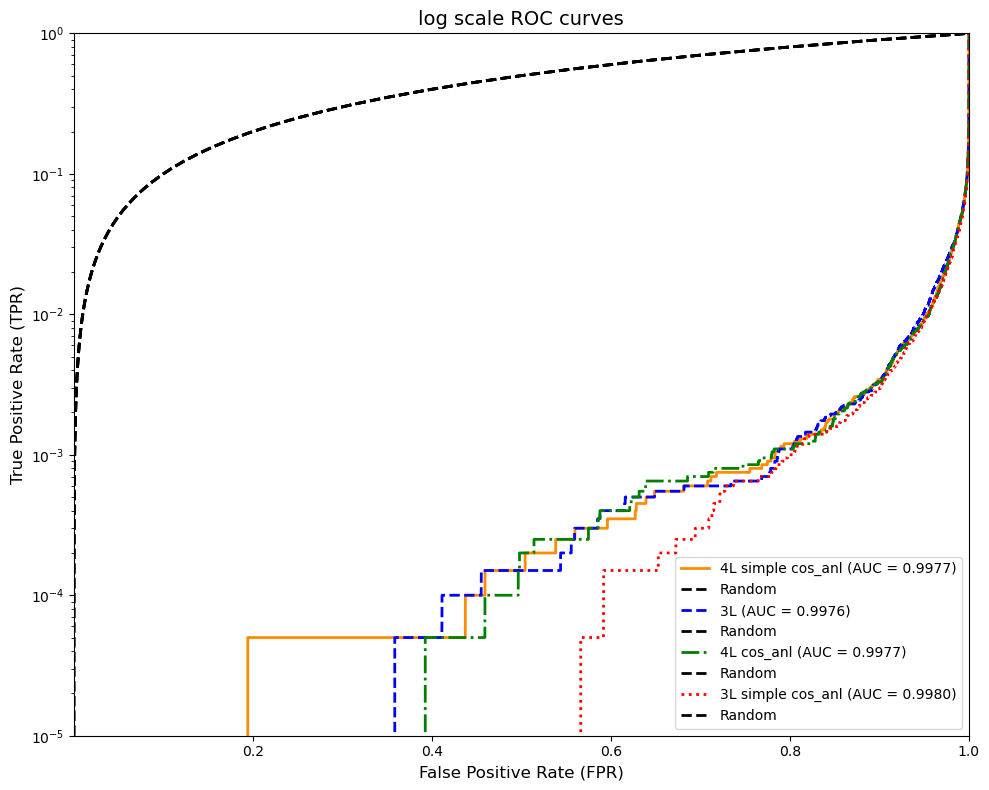

In [ ]:
# 数据预处理
df_processed = mti.preprocess_data(df, input_columns, target_column)
trans_columns = [c + '_trans' for c in input_columns]

# 分割数据集
_, test_df = train_test_split(
    df_processed,
    test_size=0.2,
    random_state=42,
    stratify=df_processed[target_column]
)

# 创建测试集数据集
test_dataset = mti.DataFrameDataset(test_df, trans_columns, target_column)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

# 获取真实标签
all_labels = []
with torch.no_grad():
    for _, labels in test_loader:
        all_labels.extend(labels.numpy())
all_labels = np.array(all_labels)

# 创建图形
plt.figure(figsize=(10, 8))

# 为每个模型绘制ROC曲线
for model_info in models_info:
    model_path = model_info["path"]

    # 首先检查检查点文件是否存在
    if not os.path.exists(model_path):
        print(f"模型文件不存在: {model_path}")
        continue

    # 加载检查点以获取模型参数信息
    try:
        checkpoint = torch.load(model_path, map_location=torch.device('cpu'))

        # 处理不同的checkpoint格式
        if "state_dict" in checkpoint:
            state_dict = checkpoint["state_dict"]
        else:
            state_dict = checkpoint

        # 处理键名不匹配问题（前缀差异）
        new_state_dict = {}
        for k, v in state_dict.items():
            if k.startswith("model."):
                k = k[6:]  # 移除"model."前缀
            new_state_dict[k] = v

        # 确定输入特征大小
        if "layer1.weight" in new_state_dict:
            input_size = new_state_dict["layer1.weight"].shape[1]
            print(f"模型 {model_info['name']} 的输入特征大小: {input_size}")
        else:
            print(f"无法确定模型 {model_info['name']} 的输入特征大小，使用默认值")
            input_size = len(input_columns)

        # 根据检测到的输入大小创建模型
        model_class = model_info["model_class"]
        model_args = model_info["model_args"].copy()
        model_args["input_size"] = input_size

        model = model_class(**model_args)

        # 尝试加载state_dict
        try:
            model.load_state_dict(new_state_dict)
            print(f"成功加载模型 {model_info['name']}")
        except Exception as e:
            print(f"直接加载失败: {e}")
            # 如果直接加载失败，尝试部分加载
            model_state_dict = model.state_dict()
            pretrained_dict = {k: v for k, v in new_state_dict.items() if k in model_state_dict}
            print(f"加载了 {len(pretrained_dict)}/{len(model_state_dict)} 个参数")
            model.load_state_dict(pretrained_dict, strict=False)

    except Exception as e:
        print(f"加载模型 {model_info['name']} 失败: {e}")
        continue

    model.eval()

    # 使用测试集进行预测
    all_probs = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            # 确保输入维度正确
            if inputs.shape[1] != input_size:
                # 如果输入维度不匹配，进行截断或填充
                if inputs.shape[1] > input_size:
                    inputs = inputs[:, :input_size]
                else:
                    pad = torch.zeros((inputs.shape[0], input_size - inputs.shape[1]))
                    inputs = torch.cat([inputs, pad], dim=1)

            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            pos_probs = probs[:, 1].numpy()
            all_probs.extend(pos_probs)

    all_probs = np.array(all_probs)

    # 计算ROC曲线
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    # 绘制ROC曲线
    plt.semilogy(tpr, fpr, 
                color=model_info["color"], 
                linestyle=model_info["linestyle"],
                lw=2,
                label=f'{model_info["name"]} (AUC = {roc_auc:.4f})')
    


    
    # 生成随机分类器的点
    random_fpr = np.logspace(-5, 0, 100)  # 在对数空间中均匀采样
    random_tpr = random_fpr  # 随机分类器满足 TPR = FPR
    plt.semilogy(random_tpr, random_fpr, 'k--', lw=2, label='Random')

# 设置图形属性
plt.xlim([1e-5, 1.0])  # 设置x轴范围，避免0值
plt.ylim([1e-5, 1.0])  # 设置y轴范围，避免0值
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('log scale ROC curves', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
# plt.grid(True, which="both", ls="--", alpha=0.7)
plt.tight_layout()
plt.savefig('multi_model_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()
